In [3]:
# # PROJECT 1 INTRO ML GROUP 248
# ##### 3. Data visualization(s) based on suitable visualization techniques in- cluding a principal component analysis (PCA)

# %%
import importlib_resources
import numpy as np
import xlrd
from scipy.linalg import svd
import os
os.chdir(r"C:\Users\elefa\OneDrive - Danmarks Tekniske Universitet\DTU\FALL2024\02450_ITMLADM\PROJECT\IntroML")
from matplotlib.pyplot  import figure, legend, plot, show, title, xlabel, ylabel, grid, subplot, scatter
from matplotlib.pyplot import *
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

filename = "raw data.csv"
df = pd.read_csv(filename, sep=";")
df.head()

# %%
# Remove columns and rows with all NaN values
df_cleaned = df.dropna(axis=1, how='all')
df_cleaned = df_cleaned.dropna(axis=0, how='all')

# %%
# Identify columns with object data types that need conversion
columns_to_convert = ['2P%', '3P%', 'FT%']
df_cleaned[columns_to_convert] = df_cleaned[columns_to_convert].astype(str).apply(lambda x: x.str.replace(',', '.').astype(float))

# %%
features = df_cleaned.columns
# Encode the player names as integers
players = df_cleaned.iloc[:, 0]
player_codes = players.astype('category').cat.codes
K = player_codes.max() + 1  
player_encoding = np.zeros((player_codes.size, K))
player_encoding[np.arange(player_codes.size), player_codes] = 1
# Combine the player encoding with the rest of the data matrix
X_combined = np.hstack((player_encoding, df_cleaned.iloc[:, 1:].values))

# Remove the player names from the feature set
df_numeric =df_cleaned[features[1:]]
features_numeric = df_numeric.columns

attributeNames = players.unique().tolist() + features_numeric.tolist()

In [5]:

import importlib_resources
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import rlr_validate

In [8]:
# Divide X into new X and Y
X_new = X_combined[:, :-1]
y = X_combined[:, -1]

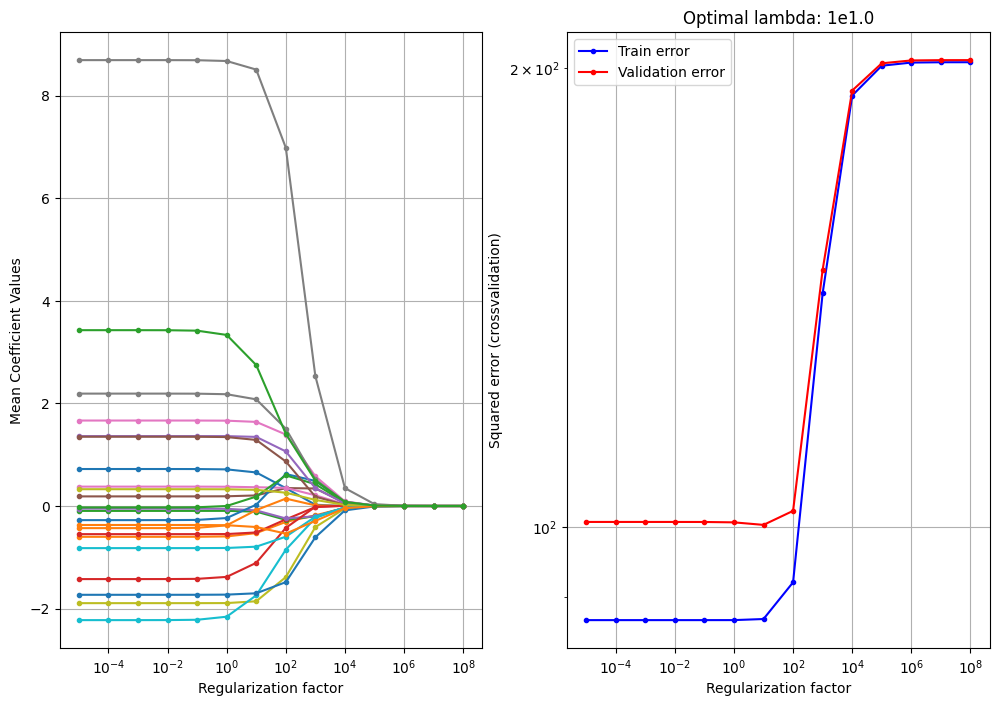

Linear regression without feature selection:
- Training error: 83.58001941701554
- Test error:     93.07830353542047
- R^2 train:     0.5650505427434672
- R^2 test:     0.5075175940520554

Regularized linear regression:
- Training error: 83.75869341286428
- Test error:     92.59272485861857
- R^2 train:     0.564120725329421
- R^2 test:     0.5100868174472521

Weights in last fold:
         Offset            5.03
         Offset            0.66
         Offset           -0.53
         DONCIC           -0.11
          JAMES           -0.52
          TATUM           -0.08
          DAVIS             0.2
          JOKIC            0.36
          CURRY            8.53
  ANTETOKOUNMPO           -1.86
            WIN           -1.79
             SP           -0.01
            2PA            -0.1
            2P%            0.16
            3PA           -1.13
            3P%            1.34
            FTA            1.29
            FT%            1.64
            ORB            2.09
       

In [9]:
X = X_new
df_numeric.columns.tolist()
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames
M = M + 1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.0, range(-5, 9))

# Initialize variables
# T = len(lambdas)
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        # legend(attributeNames[1:], loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()

    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

show()
# Display results
print("Linear regression without feature selection:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("Weights in last fold:")
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 2)))

print("Ran Exercise 8.1.1")
